# MSA 2024 Phase 2 - Part 2

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## Plotting each differenced data to visualize the patterns

## 1. Load and split preprocessed data

## Weekly data

In [3]:
weekly_red_cols= pd.read_csv("weekly_reduced_df.csv", encoding='latin1',delimiter=',',header='infer')
weekly_red_cols['Order Date'] = pd.to_datetime(weekly_red_cols['Order Date'])

# Set 'Order Date' as the index
weekly_red_cols.set_index('Order Date', inplace=True)
weekly_red_cols.head()

,Discount,Sales,Profit,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Tables,Region_Central,Region_East,Region_South,Region_West,...,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Segment_Corporate,Segment_Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-12,-0.348150,-0.298677,1.334376,-0.980285,-0.828107,-1.100766,-0.649766,-0.759147,0.253935,-1.248425,...,1.408208,-0.642154,-0.069505,-0.288675,-0.069505,-0.331664,-0.591002,-1.059821,-0.891047,-0.396302
2014-01-19,2.331780,-0.897448,-0.727771,1.702600,-0.828107,-1.100766,-1.144826,-0.357359,-0.374857,-0.513850,...,-0.469403,-0.642154,-0.069505,-0.288675,-0.069505,0.248051,-0.591002,-0.027302,-0.891047,-0.931568
2014-01-26,-1.369075,-0.731374,0.566818,-0.085990,-0.828107,-1.100766,0.340354,-1.160935,2.140311,-0.881137,...,3.285820,-0.642154,-0.069505,-0.288675,-0.069505,-0.331664,-0.591002,-0.543562,-0.891047,0.138963
2014-02-02,-0.041872,-1.154168,-0.216473,-0.085990,-1.249246,-0.383025,-1.144826,-1.160935,-1.003649,-0.513850,...,-0.469403,-0.642154,-0.069505,-0.288675,-0.069505,-0.331664,-0.591002,-1.059821,-1.314192,-0.931568
2014-02-09,-2.185815,-1.403639,-0.176628,-0.980285,-1.249246,-1.100766,-1.144826,-1.160935,-1.003649,-0.881137,...,-0.469403,-0.642154,-0.069505,-0.288675,-0.069505,-0.331664,-0.591002,-1.059821,-1.314192,-0.396302


## 2. Choose an algorithm

In [4]:
#checking for autocorrelation to help identify the repeating patterns in the data and help us select the right terms when fitting our time series model
autocorrelation_lag1 = weekly_red_cols['Sales'].autocorr(lag=1)
print("1 week Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = weekly_red_cols['Sales'].autocorr(lag=2)
print("2 week Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = weekly_red_cols['Sales'].autocorr(lag=3)
print("3 week Lag: ", autocorrelation_lag3)

autocorrelation_lag4 = weekly_red_cols['Sales'].autocorr(lag=4)
print("4 week Lag: ", autocorrelation_lag4)

autocorrelation_lag5 = weekly_red_cols['Sales'].autocorr(lag=5)
print("5 week Lag: ", autocorrelation_lag5)

autocorrelation_lag6 = weekly_red_cols['Sales'].autocorr(lag=6)
print("6 week Lag: ", autocorrelation_lag6)

autocorrelation_lag7 = weekly_red_cols['Sales'].autocorr(lag=7)
print("7 week Lag: ", autocorrelation_lag7)
autocorrelation_lag8 = weekly_red_cols['Sales'].autocorr(lag=52)
print("52 week Lag: ", autocorrelation_lag8)


1 week Lag:  0.4051619988496448
2 week Lag:  0.35979726401671297
3 week Lag:  0.2724814318740801
4 week Lag:  0.22777007611698485
5 week Lag:  0.0963984427653425
6 week Lag:  0.11803063033763292
7 week Lag:  0.15527264527104093
52 week Lag:  0.5122085115186871


From these lag terms we can see that the weekly data has significant correlation at  1 week and 52 week intervals.

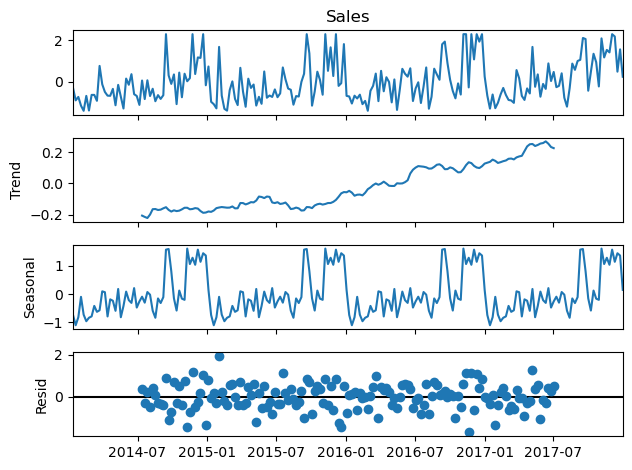

In [5]:
#Dcomposing the data to separate the trend and seasonal components to make it easier to visualize

result = seasonal_decompose(weekly_red_cols['Sales'], model='additive', period = 52)
# Plot decomposition
result.plot()
plt.show()

Look at the decomposition plots there's an increasing trend and annual seasonal pattern present in our dataset. We can see that differencing the trend and seasonal components leads to relatively normally distributed residuals, with constant mean of 0. This is a good indication that we need to include the trend and seasonal differencing parameters in our model to capture the underlying patterns and take are of the autocorrelation.

In [6]:
#Extract residuals from the decomposition plots to see if there are any unusual values we can visibly see 
residuals=result.resid
adf_test = adfuller(residuals.dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -15.727616087405536
p-value: 1.3010260612558464e-28


The ADF statistic shows a statistically significant p-value which means that the residuals of the decomposition model are stationary. The stationarity assumption is one of the key aspects of the time series models (SARIMA) we intend to use. 

## Visual inspection of differencing 

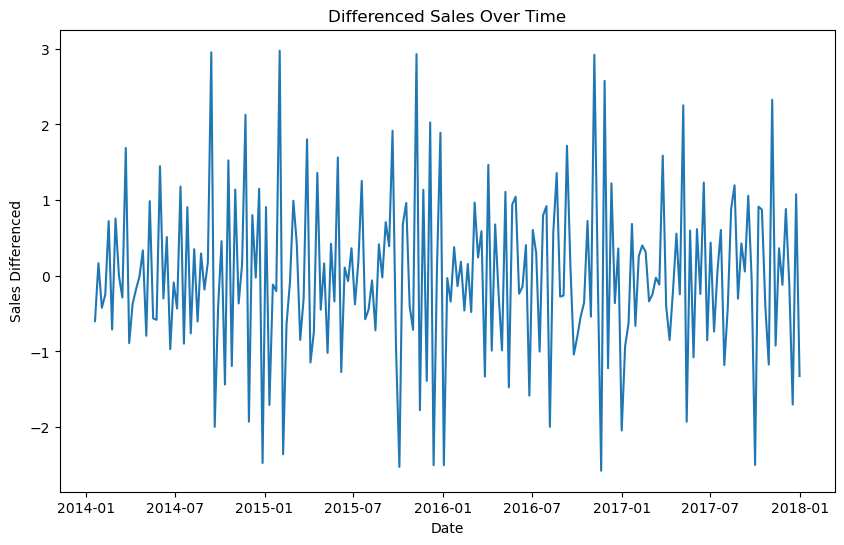

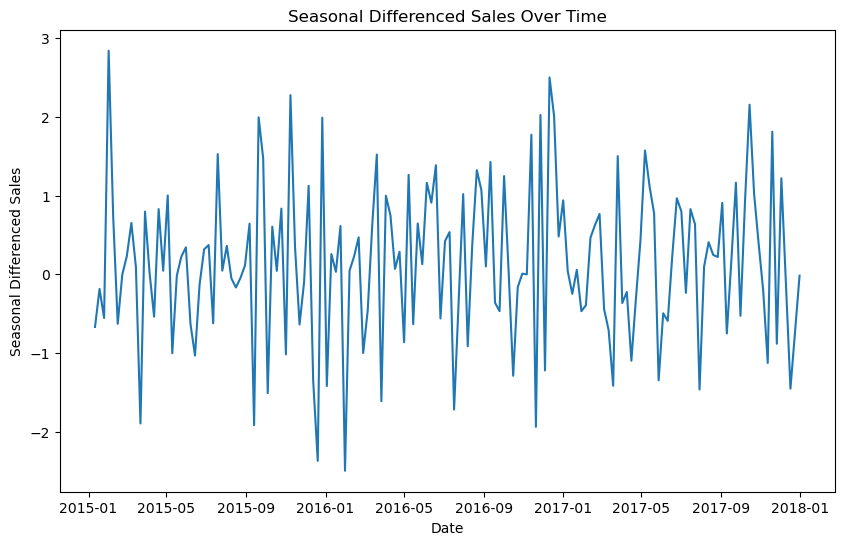

In [7]:
# First-order differencing
data_diff = weekly_red_cols['Sales'].diff().dropna()

# Seasonal differencing
data_seasonal_diff = weekly_red_cols['Sales'].diff(52).dropna()

# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(data_diff.index, data_diff)
plt.xlabel('Date')
plt.ylabel('Sales Differenced')
plt.title('Differenced Sales Over Time')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data_seasonal_diff.index, data_seasonal_diff)

plt.xlabel('Date')
plt.ylabel('Seasonal Differenced Sales')
plt.title('Seasonal Differenced Sales Over Time')
plt.show()

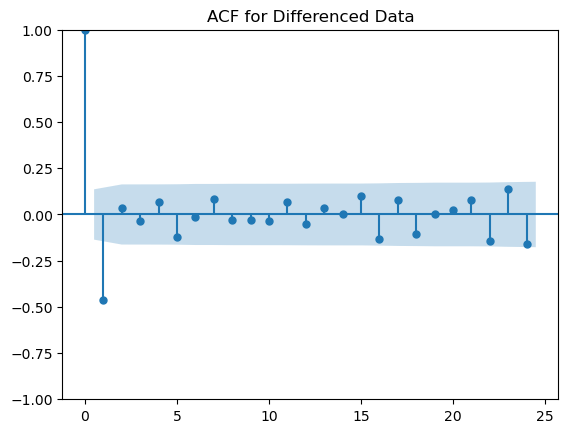

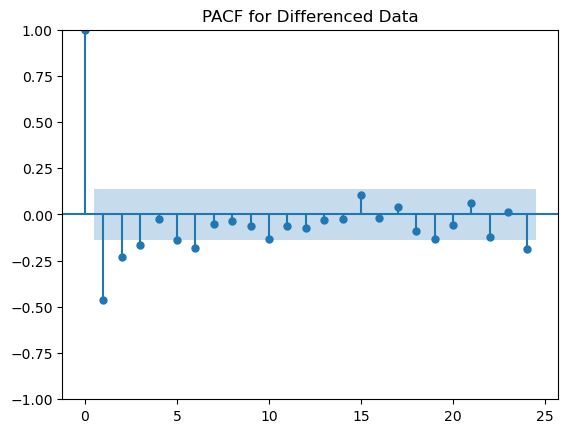

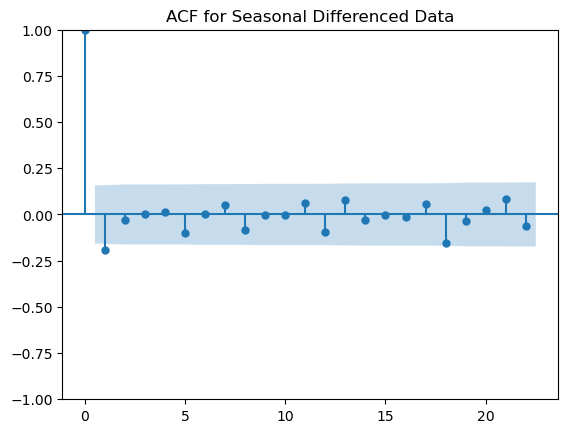

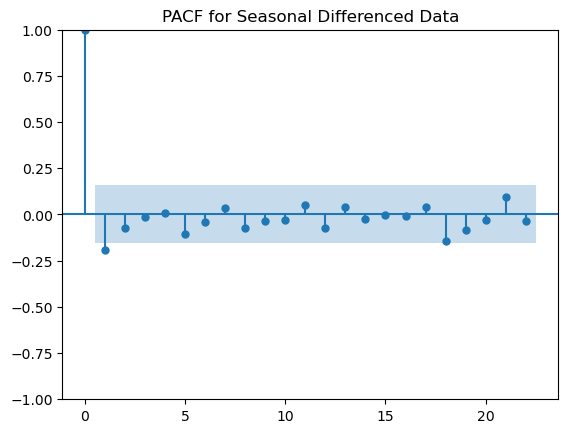

In [8]:

# ACF and PACF plots for differenced data
plot_acf(data_diff)
plt.title('ACF for Differenced Data')
plt.show()

plot_pacf(data_diff)
plt.title('PACF for Differenced Data')
plt.show()

# ACF and PACF plots for seasonal differenced data
plot_acf(data_seasonal_diff)
plt.title('ACF for Seasonal Differenced Data')
plt.show()

plot_pacf(data_seasonal_diff)
plt.title('PACF for Seasonal Differenced Data')
plt.show()

From the ACF and PACF plots we can get an idea of what the AR and MA parameters might be. 

## 3. Train and test a model

In [55]:
y = weekly_red_cols['Sales']
X = weekly_red_cols.drop(columns=['Sales'])

# Train-test split
train_size = int(len(X) * 0.8)  # 80-20 split
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



Initially i fit the SARIMAX model with all the exogenous variables however this resulted in alot of non significant terms. Therefoer in the following code i have narrowed the exogenous variables to the statistically significant ones.

In [58]:

#Selecting only the statistically significant exogenous variables 
significant_columns = ['Region_West', 'Sub-Category_Chairs', 'State_Colorado', 'Segment_Corporate']
X_train = X_train[significant_columns]
X_test = X_test[significant_columns]


In [59]:
X_train.head()

,Region_West,Sub-Category_Chairs,State_Colorado,Segment_Corporate
Order Date,,,,
2014-01-12,-1.248425,-0.828107,-0.322147,-0.891047
2014-01-19,-0.513850,-0.828107,-0.322147,-0.891047
2014-01-26,-0.881137,-0.828107,-0.322147,-0.891047
2014-02-02,-0.513850,-1.249246,-0.322147,-1.314192
2014-02-09,-0.881137,-1.249246,-0.322147,-1.314192


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  166
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                -122.156
Date:                             Sun, 28 Jul 2024   AIC                            260.313
Time:                                     23:19:09   BIC                            282.132
Sample:                                 01-12-2014   HQIC                           269.167
                                      - 03-12-2017                                         
Covariance Type:                               opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Region_West             0.2528      0.096      2.637      0.008       0.065       0.441


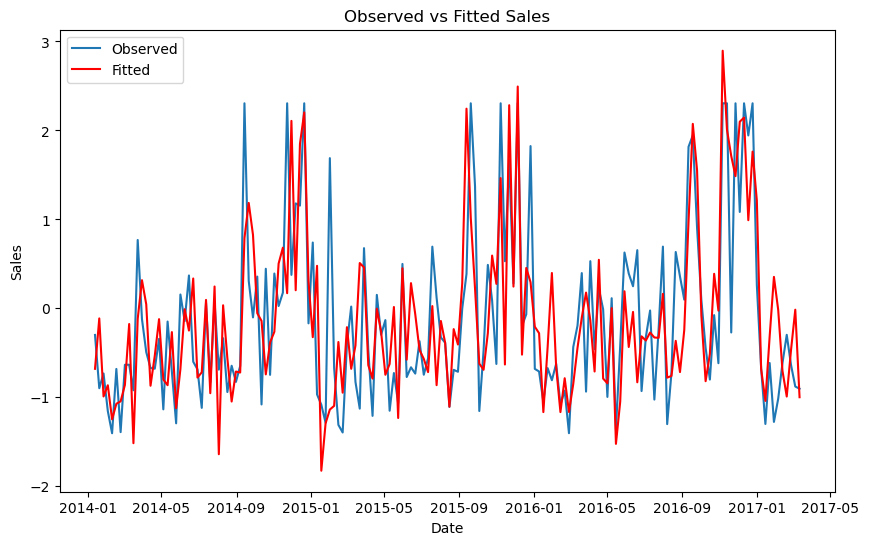

In [60]:



np.random.seed(42)

# Fitting SARIMA model with exogenous variables
model = SARIMAX(y_train.asfreq('W-SUN'), exog=X_train.asfreq('W-SUN'), order=(1, 1, 1), seasonal_order=(1, 1, 0, 52), freq='W-SUN')

model_results = model.fit()

# Printing model summary
print(model_results.summary())

# Plotting the fitted values
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Observed')
plt.plot(model_results.fittedvalues, label='Fitted', color='red')
plt.title('Observed vs Fitted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


After trying a few combinations of the parameters such as:\
(3, 1, 1)(1, 1, 1, 52) \
(2, 1, 1)(1, 1, 1, 52) \
(1, 1, 1)(1, 1, 1, 52) \
We finally arrived at the combination that resulted in significant p-values whilst still capturing the autocorrelation we saw was present in the data from the ACF & PACF plots.

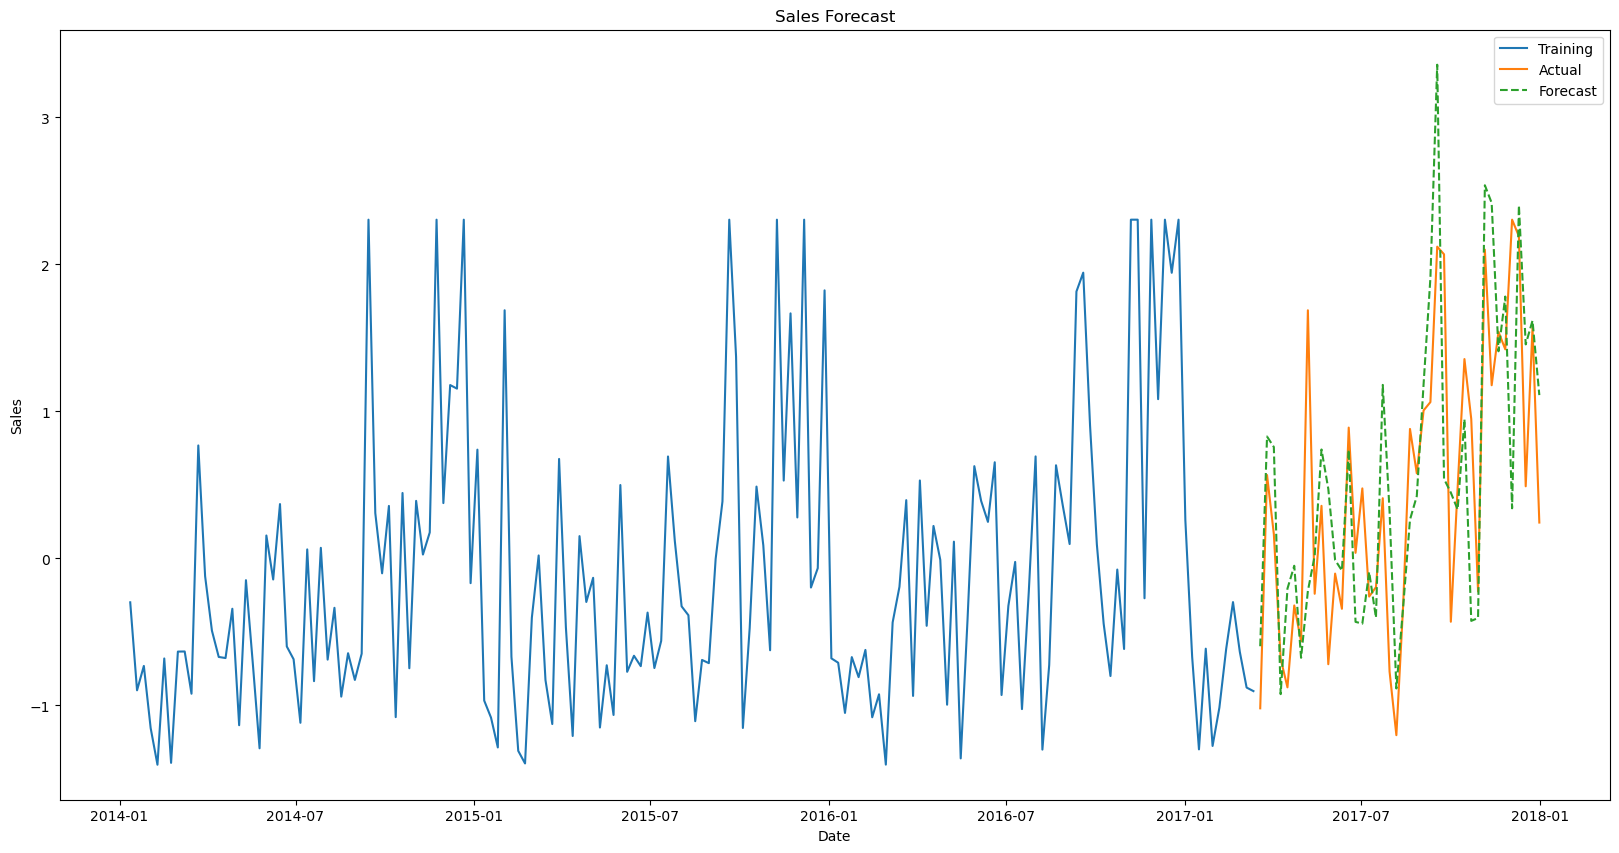

In [61]:
forecasts = model_results.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test.asfreq('W-SUN'), dynamic=False)

plt.figure(figsize=(20, 10))
plt.plot(y_train, label='Training')
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, forecasts, label='Forecast', linestyle='--')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

I started with a model that included all exogenous variables from the preprocessed dataset and AR & MA terms. This then gave us significant coefficients for both AR & MA terms but alot of the exogenous variables had p-value higher than 0.05 and were non significant. Therefore only the variables with statistically significant coefficients were used in the model. Those were 'Region_West', 'Sub-Category_Chairs', 'State_Colorado', 'Segment_Corporate'.

The model was then reran with significant only variables and AR & MA terms included. This resulted in the trend MA term having a p-value slightly higher than 0.05. However the model with this non-significant MA term resulted in lower AIC and BIC, as well as better performance metrics such as MAE, MSE, and RMSE. This means that despite the non-significant MA term the model is a better fit for the data. This might have happened because the model still benefits from the inclusion of the MA term even if it's not individually significant. The overall performance metrics and model selection criteria (AIC, BIC) are more reliable indicators of model quality than individual parameter significance alone.


## 4. Evaluate the model 

In [62]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, forecasts)
mse = mean_squared_error(y_test, forecasts)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.584558771792801
Mean Squared Error (MSE): 0.5942315330823243
Root Mean Squared Error (RMSE): 0.7708641469690521


Both MAE and RMSE are in the original scale of the data. MAE \\$0.58 means that on average, our model's predictions are off by \\$0.58 for each week's sales. However MAE applies a linear penalty to errors, whereas RMSE applies a quadratic penalty. This means RMSE is more sensitive to larger errors. 
RMSE of \\$0.77 indicates that the typical deviation of our model's predictions from actual weekly sales is around \\$0.77.
MSE of 0.59 is less interpretable in financial terms but suggests that the errors are fairly low due to its low value.

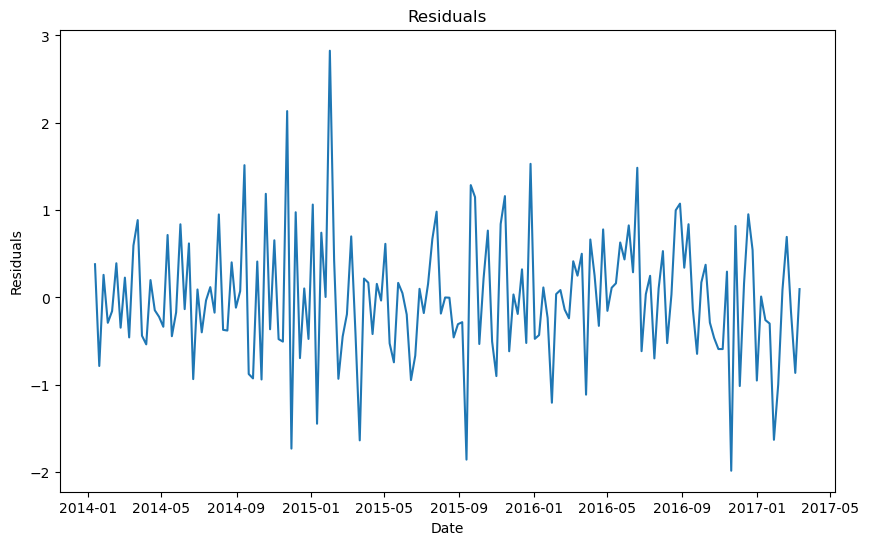

count    166.000000
mean      -0.002892
std        0.724377
min       -1.983973
25%       -0.454922
50%        0.002755
75%        0.409230
max        2.825552
dtype: float64


In [63]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(model_results.resid)
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Check residuals summary statistics
print(model_results.resid.describe())

In [64]:

adf_test = adfuller(model_results.resid.dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -15.557909482869333
p-value: 2.060188628619188e-28


## Predictions for exog model


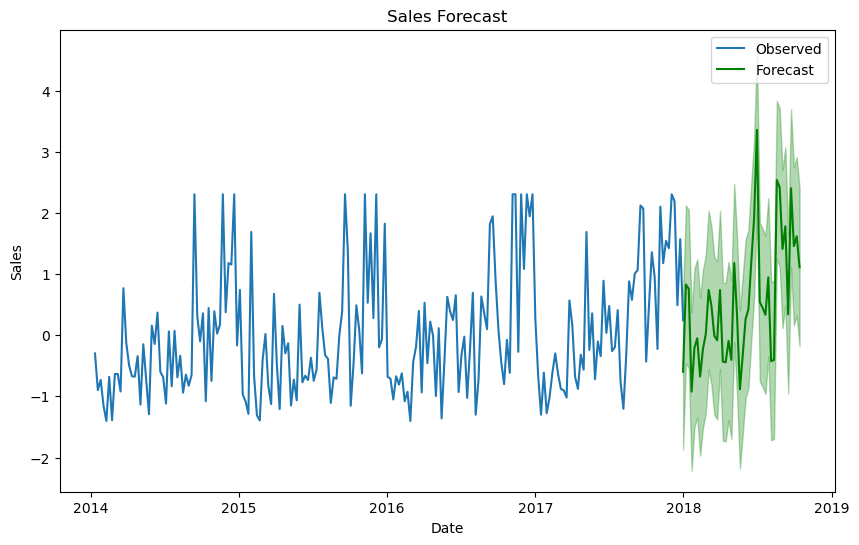

In [67]:
# As i am using exogenous variables for training, Forecasting will also need these variables
#Here, I assume X_test can be used for the future period
forecast_steps = 42  #using 42 because i don't have enough exogenous variables for 52 periods
forecast_index = pd.date_range(start=weekly_red_cols.index[-1], periods=forecast_steps, freq='W')

# Creating the future exogenous variables (X_future) for the forecast period
X_future = X_test.asfreq('W-SUN').iloc[:forecast_steps]

# Getting the forecast with exogenous variables
forecast = model_results.get_forecast(steps=forecast_steps, exog=X_future)

# Extracting forecast values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(weekly_red_cols['Sales'], label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='green')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Model Tuning 

## 5. Summary

The data was divided into a 80-20 split for training and testing. Initially a base model was fit on the training data. The base model included all the exogenous variables and the AR & MA terms. I ended up with (1, 1, 1)X(1, 1, 0, 52) model after removing the non significant exogenous variables and reruninng the model with different combinations of AR & MA terms. 

Through my data exploration and inspection of the ACF and PACF plots i had identified this to be a AR MA time series at the minimum. Therefore even though the MA term seems to have an insignificant p-value theres strong evidence to suggest it's still benefiticial for the model's performance. This model had the best performance metrics which supports the inclusion of those terms. The diangnostics indicated that the model assumptions were satisfied as the residuals were (white noise) normally distributed, with constant mean of 0. The ADF statistic confirmed the stationarity assumption with a significant p-value. This showed that the model had captured majority of the patterns in the timeseries data and as we could see from the residuals plot there was no trend or autocorrelation remaining.

Overall the SARIMAX model with significant exogenous variables and the MA term, despite its non-significance, provided a robust and reliable forecast for weekly sales. The steps taken ensured a thorough evaluation and highlighted the importance of model diagnostics and selection criteria in developing accurate time series models.

Possible next steps to improve would be trying to account for weekends, days leading up to public holdiays. This is because in theory those occasions would have significant effects on the weekly sales. For example during the christmas period sales would likely increase drastically and hence capturing this effect on the model thorugh a one hot encoded (dummy) variable might improve the model's performance.